In [1]:
!pip3 install pandas
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import torch.nn.init as init

from lib.layers import *
from lib.utils.timer import Timer
from lib.utils.data_augment import preproc
from lib.modeling.model_builder import create_model
from lib.modeling.discriminator.DNet import D_Net
from lib.dataset.dataset_factory import load_data
from lib.utils.config_parse_mimic_MOB_in_MOB import cfg
# from lib.utils.config_parse_mimic_VOC_COCO_ZERO import cfg1
# from lib.utils.config_parse_mimic_VOC_COCO_LR_ARD import cfg
from lib.utils.eval_utils import *
from lib.utils.visualize_utils import *

In [2]:
test_loader = load_data(cfg.DATASET, 'test') if 'test' in cfg.PHASE1 else None

In [3]:
model_student, priorbox = create_model(cfg.MODEL)
model_student.load_state_dict(torch.load('./Weights/MobileNet2_D1Linear_Ones_VOC/ssd_lite_mobilenet_v2_voc_epoch_120.pth'))
priors = Variable(priorbox.forward(), volatile=True)
detector = Detect(cfg.POST_PROCESS, priors.cpu())

==>Feature map size:
[(19, 19), (10, 10), (5, 5), (3, 3), (2, 2), (1, 1)]


/storage/3050/FinogeevE/prj/ssds.pytorch-master_MobileNet_2/lib/layers/modules/l2norm.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)
/storage/3050/FinogeevE/prj/ssds.pytorch-master_MobileNet_2/lib/modeling/model_builder.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = torch.autograd.Variable(x, volatile=True) #.cuda()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
model_student.base[0][0].weight[0]

tensor([[[ 0.0565,  0.0197,  0.0211],
         [ 0.0761,  0.0094,  0.0273],
         [ 0.0433, -0.0152,  0.0154]],

        [[ 0.0461,  0.0194,  0.0300],
         [ 0.0581,  0.0041,  0.0255],
         [ 0.0346, -0.0210,  0.0209]],

        [[ 0.0358,  0.0193,  0.0306],
         [ 0.0402,  0.0212,  0.0282],
         [ 0.0173, -0.0214, -0.0033]]], grad_fn=<SelectBackward>)

In [4]:
model_teacher = create_model(cfg.MODEL_MIMIC)
model_teacher.load_state_dict(torch.load('./Weights/Original_V3_VOC/ssd_lite_mobilenet_v2_voc_epoch_266_MAX_69.5.pth'))

==>Feature map size:
[(19, 19), (10, 10), (5, 5), (3, 3), (2, 2), (1, 1)]


<All keys matched successfully>

In [7]:
model_teacher.base[0][0].weight[0]

tensor([[[ 0.0149,  0.0001,  0.0183],
         [ 0.0317, -0.0209,  0.0091],
         [ 0.0102, -0.0318, -0.0112]],

        [[ 0.0102, -0.0011,  0.0188],
         [ 0.0204, -0.0272,  0.0015],
         [ 0.0114, -0.0273, -0.0045]],

        [[-0.0218, -0.0163, -0.0064],
         [-0.0098, -0.0265, -0.0130],
         [-0.0247, -0.0301, -0.0217]]], grad_fn=<SelectBackward>)

In [8]:
pos = MultiBoxLoss(cfg.MATCHER, priors, True)
model_student.eval().cuda()
# model_teacher.eval().cuda()
print('Sucsessful')

Sucsessful


In [9]:
data_iterator = iter(test_loader)

In [10]:
images, targets = next(data_iterator)
images = Variable(images.cuda())
targets = [Variable(anno.cuda(), volatile=True) for anno in targets]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
images.shape

torch.Size([1, 3, 300, 300])

In [12]:
rgb_image = cv2.cvtColor(images.cpu().squeeze(0).permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)
scale = torch.tensor([image.shape[1], image.shape[0], image.shape[1], image.shape[0]], dtype=torch.float)
plt.imshow(rgb_image)

NameError: name 'image' is not defined

In [14]:
out_student, FM_student = model_student(images, phase='train_mimic')
loss1,loss2,pos = pos(out_student, targets, 'train_mimic')
FM_teacher = model_teacher(images, phase='feature')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


RuntimeError: copy_if failed to synchronize: device-side assert triggered

In [15]:
fm = FM_student[0]
print(fm.size())

torch.Size([1, 96, 19, 19])


In [16]:
three = pos[:,:361*6].float()
print(three.size())

TypeError: 'MultiBoxLoss' object is not subscriptable

In [17]:
answer = three.view(32,19*19,-1).sum(dim=-1)>0

NameError: name 'three' is not defined

In [18]:
answer.float().sum()

NameError: name 'answer' is not defined

In [19]:
fm = fm.view(32,-1,512)

RuntimeError: shape '[32, -1, 512]' is invalid for input of size 34656

In [20]:
a = fm[answer]
a.size()

NameError: name 'answer' is not defined

In [21]:
print(loss1)
print(loss2)
print(pos.size())

NameError: name 'loss1' is not defined

In [22]:
sum(sizes[:3]*boxes[:3])

TypeError: can't multiply sequence by non-int of type 'list'

In [23]:
sizes = torch.tensor([361, 100, 25, 9, 4, 1])
boxes = torch.tensor([6, 6, 6, 6, 4, 4])
for j in range(6):
    needed = torch.zeros(sizes[j])
    start = sum(sizes[:j]*boxes[:j])
    print(start)
    for k in range(sizes[j]):
        if sum(POS[0][start + k*boxes[j]:start + k*boxes[j]+boxes[j]]) > 0:
            needed[k]=1
    needed = needed.bool()  
    print(sum(needed.float()))

RuntimeError: CUDA error: device-side assert triggered

In [24]:
eval_student= model_student(images, phase='eval')
eval_teacher= model_teacher(images, phase='eval')

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'eval_student' is not defined

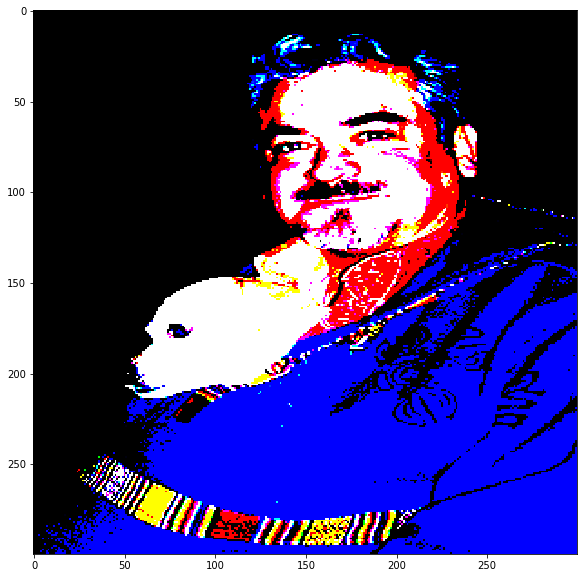

In [25]:
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
detections = detector.forward(eval_student)
print(detections.size())
# labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',\
#           'boat', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'bottle', 'chair',\
#           'couch', 'potted plant', 'dining table', 'tv']
labels = (  # always index 0
    'person', 'bicycle', 'car', 'motorbike',
    'aeroplane', 'bus', 'train', 'boat', 'bird',
    'cat', 'dog', 'horse', 'sheep',
    'cow', 'bottle', 'chair',
    'sofa', 'pottedplant', 'diningtable', 'tvmonitor')

for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.1:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
#         print(label_name)
#         print(score)
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

In [26]:
print(FM_student[0].size())
print(FM_teacher[0].size())

torch.Size([1, 96, 19, 19])


NameError: name 'FM_teacher' is not defined

In [27]:
# S1 = FM_student[0].permute(0,2,3,1).view(-1,512)
# print(S1.size())
# T1 = FM_teacher[0].permute(0,2,3,1).view(-1,512)
# print(T1.size())
# O1 = FM_original[0].permute(0,2,3,1).view(-1,512)
# print(O1.size())
S1 = FM_student[0].view(96,-1)
print(S1.size())
T1 = FM_teacher[0].view(96,-1)
print(T1.size())

torch.Size([96, 361])


NameError: name 'FM_teacher' is not defined

In [ ]:
dfs = pd.DataFrame(S1.detach().numpy())
dft = pd.DataFrame(T1.detach().numpy())

In [ ]:
print(dfs.shape)
dfs.head()

In [ ]:
st = dfs.corrwith(dft)
st

In [ ]:
st = dfs.corrwith(dft)
print(st.min())

In [13]:
model_student.eval().cuda()
model_teacher.eval().cuda()
sizes = [361, 100, 25, 9, 4, 1]
boxes = [6, 6, 6, 6, 4, 4]
mean_corr = [[0,0,0] for i in range(6)]
for i in range(1):
    img = dataset.pull_image(i)
    images = Variable(dataset.preproc(img)[0].unsqueeze(0).cuda(), volatile=True)
    out_student, FM_student = model_student(images, phase='train_mimic')
    FM_teacher = model_teacher(images, phase='feature')
    for j in range(6):
        needed = torch.zeros(sizes[j])
        for k in range(sizes[j]):
            if sum(b[0][k*boxes[j]:k*boxes[j]+boxes[j]]) > 0:
                needed[k]=1
        needed = needed.bool()
        S = FM_student[j].view(FM_student[j].size(1),-1)
        print(S.size())

        S = FM_student[j].view(FM_student[j].size(1),-1)
        T = FM_teacher[j].view(FM_teacher[j].size(1),-1)
        dfs = pd.DataFrame(S.cpu().detach().numpy())
        dft = pd.DataFrame(T.cpu().detach().numpy())
        st = dfs.corrwith(dft)
        mean_corr[j][0] += st.mean()
        mean_corr[j][1] += st.max()
        mean_corr[j][2] += st.min()
    if i%20==0 and i>0:
        print(mean_corr)
        print('====================')

NameError: name 'dataset' is not defined

In [ ]:
f = open('./Test/Te.txt', 'w')
print('Stud-Teach||Orig-Teach||Orig-Stud')
f.write('Stud-Teach||Orig-Teach||Orig-Stud \n')
for i in range(6):
    print('{st:9.5f} || {ot:8.5f} || {so:8.5f}'.format(st = mean_corr[i][0]/100,\
                                                     ot=mean_corr[i][1]/100,so=mean_corr[i][2]/100))
    f.write('{st:9.5f} || {ot:8.5f} || {so:8.5f} \n'.format(st = mean_corr[i][0]/100,\
                                                     ot=mean_corr[i][1]/100,so=mean_corr[i][2]/100))
f.close()

In [ ]:
a = torch.rand(5,6,1)

In [ ]:
a

In [ ]:
a.view(-1,1)

In [ ]:
b = torch.randint(0,2,(1,2990))

In [ ]:
b.size()

In [ ]:
k = torch.zeros(361)
for i in range(19*19):
    if sum(b[0][i*6:i*6+6]) > 0:
        k[i]=1
k = k.bool()
print(k)

In [ ]:
c = torch.ones(96,361)
print(c.transpose(0,1).size())
c = c.transpose(0,1)[k]

In [ ]:
c.size()